In [1]:
import numpy as np
import scipy.integrate
import scipy.interpolate
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
from astropy.table import Table
import astropy.units as u
import itertools

In [2]:
rc('figure', figsize=(12,8))
rc('font', size=18)
rc('lines', linewidth=3)
rc('axes', linewidth=2)
rc('xtick.major', width=2)
rc('ytick.major', width=2)

data = Table.read('survey_x.txt', format='ascii.commented_header')
data_deep = Table.read('survey_x_deep.txt', format='ascii.commented_header')
data.colnames

['RA', 'DEC', 'R_PETRO', 'Z']

# Differential number counts

In [3]:
nbins = 20
dN, bins = np.histogram(data['R_PETRO'], bins=nbins)
dS = np.diff(bins)[0]

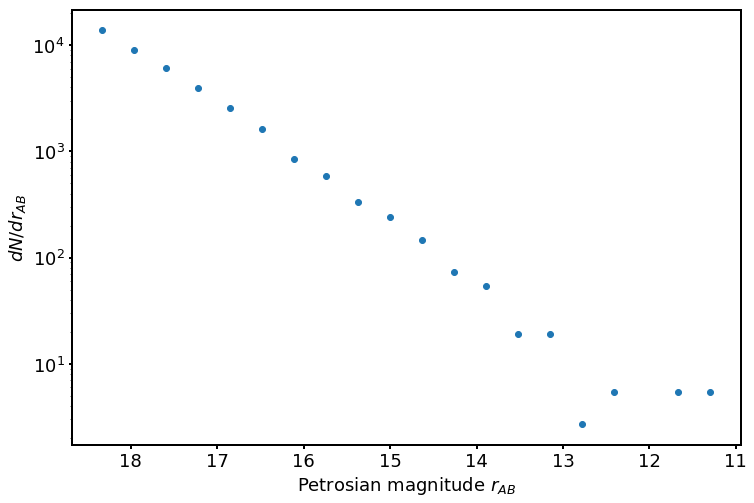

In [4]:
fig, ax = plt.subplots()
ax.invert_xaxis()
ax.set_xlabel(r'Petrosian magnitude $r_{AB}$')
ax.set_ylabel(r'$dN/dr_{AB}$')
ax.set_yscale('log')
ax.scatter(bins[:-1], dN/dS);

# Redshift distribution

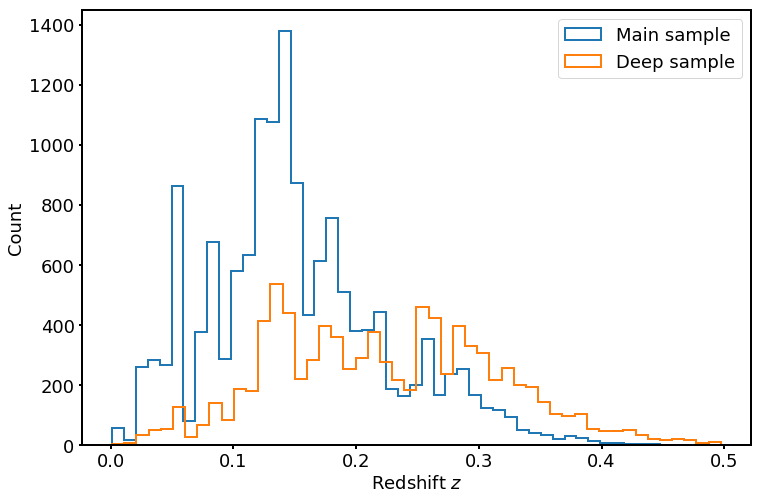

In [5]:
fig, ax = plt.subplots()
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'Count')
ax.hist(data['Z'], bins=50, histtype='step', lw=2, label='Main sample');
ax.hist(data_deep['Z'], bins=50, histtype='step', lw=2, label='Deep sample');
ax.legend();

# Luminosity function

In [6]:
# To calculate absolute magnitudes, need distances
# Obtain from luminosity distance d_L

# Assume the following cosmological parameters
Wm = 0.3
Wde = 0.7
h = 0.72
H0 = (100 * u.km / u.megaparsec / u.second).decompose() * h
c = 3e8 * u.m / u.second

## Comoving distance

$$x(z)=\int_0^z\frac{\mathrm{d}\,z'}{E(z')}$$

with $$E(z)=\left[\Omega_m(1+z)^3+\Omega_\Lambda\right]^{1/2}$$

In [7]:
# we don't care about the error estimates
def numint(*args):
    return scipy.integrate.quad(*args)[0]

def E(z):
    return np.sqrt(Wm * (1 + z)**3 + Wde)

def cmdist(z):
    if type(z) == np.float64:
        z = [z]
    func = lambda z: 1 / E(z)
    return (c / H0) * np.array([numint(func, 0, zval) for zval in z])


## Luminosity distance

$$d_L=(1+z)x$$

In [8]:
def lumdist(z):
    return (1 + z) * cmdist(z)

luminosity_distances = lumdist(data['Z'])

## Absolute magnitudes

$$M = m - 5\log\left(\frac{d}{10\mathrm{pc}}\right)-K$$

with $$K(z) = 2.5\log(1+z)$$

In [9]:
def k_correction(z):
    return 2.5 * np.log10(1 + z)

# M = m - 5(log(d/10) - K)
k_corr = k_correction(data['Z'])
abs_mag = data['R_PETRO'] - 5 * (np.log10(luminosity_distances.to(u.parsec)
                                          / u.parsec) - 1) - k_corr

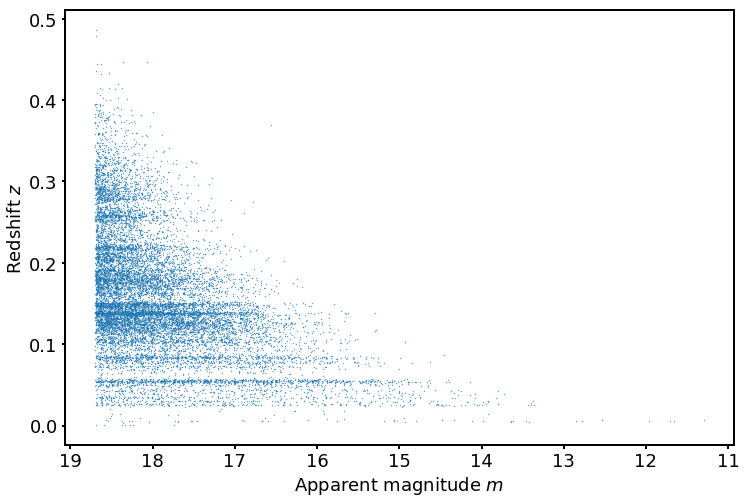

In [10]:
fig, ax = plt.subplots()
ax.invert_xaxis()
ax.set_xlabel(r'Apparent magnitude $m$')
ax.set_ylabel(r'Redshift $z$')
ax.scatter(data['R_PETRO'], data['Z'], s=0.1);

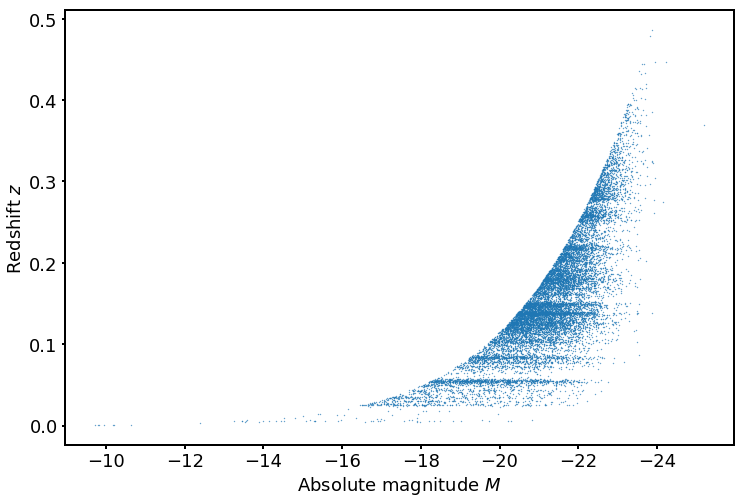

In [11]:
fig, ax = plt.subplots()
ax.invert_xaxis()
ax.set_xlabel(r'Absolute magnitude $M$')
ax.set_ylabel(r'Redshift $z$')
ax.scatter(abs_mag, data['Z'], s=0.1);

## Sampling

To calculate the luminosity function, need a complete (sub)sample of the survey.

Use rectangular selection function: min and max redshift, and min and max magnitudes.

Redshift range should include as many galaxes as possible for statistics, while being narrow enough that variation due to evolution is small.

Faint-end limit on absolute magnitude is set by flux limit of survey.

In [12]:
delta_z = 0.05
# histogram redshifts in delta_z increments
# and choose most-populated bin
num_zbins = int(np.ceil((np.max(data['Z']) - np.min(data['Z'])) / delta_z))
z_binned, z_bins = np.histogram(data['Z'], bins=num_zbins)
best_bin = np.argmax(z_binned)

# slices of data satisfying redshift criteria
redshift_range = np.logical_and(data['Z'] > z_bins[best_bin],
                                data['Z'] < z_bins[best_bin + 1])
z_zsel = data['Z'][redshift_range]
abs_mag_zsel = abs_mag[redshift_range]

In [13]:
# work out flux limit in absolute magnitude
uniform_zs = np.linspace(np.min(z_zsel), np.max(z_zsel), 100)
uniform_dLs = lumdist(uniform_zs)
uniform_kcorr = k_correction(uniform_zs)

flux_lim = np.max(data['R_PETRO'])
abs_mag_lim = flux_lim - 5 * (np.log10(uniform_dLs.to(u.parsec)
                                       / u.parsec) - 1) - uniform_kcorr

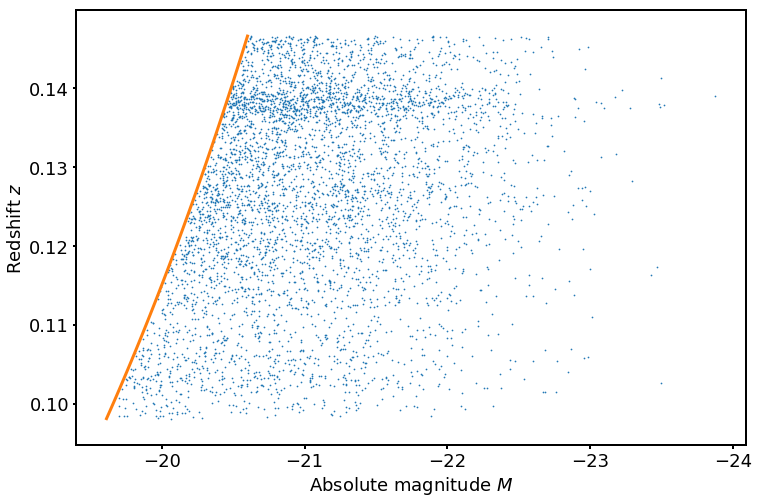

In [14]:
fig, ax = plt.subplots()
ax.invert_xaxis()
ax.set_xlabel(r'Absolute magnitude $M$')
ax.set_ylabel(r'Redshift $z$')
ax.scatter(abs_mag_zsel, z_zsel, s=0.5);
ax.plot(abs_mag_lim, uniform_zs, c='tab:orange');

In [50]:
# magnitude limit is flux limit at maximum redshift
#magnitude_range = abs_mag_zsel < abs_mag_lim[-1]
#magnitude_range = abs_mag_zsel > -23.5
magnitude_range = np.logical_and(abs_mag_zsel < abs_mag_lim[-1],
                                 abs_mag_zsel > -23.5)

# finish creating subsample
z_zfsel = z_zsel[magnitude_range]
abs_mag_zfsel = abs_mag_zsel[magnitude_range]

sample_size = np.sum(magnitude_range)
print('Sample contains {} objects'.format(sample_size))

Sample contains 3543 objects


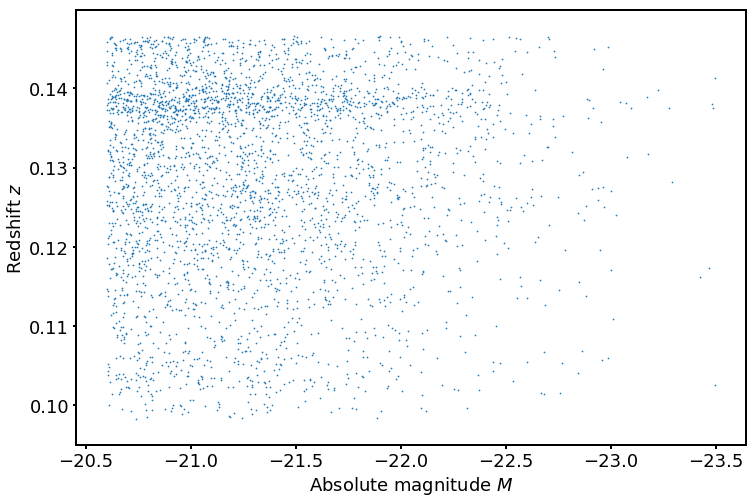

In [51]:
fig, ax = plt.subplots()
ax.invert_xaxis()
ax.set_xlabel(r'Absolute magnitude $M$')
ax.set_ylabel(r'Redshift $z$')
ax.scatter(abs_mag_zfsel, z_zfsel, s=0.5);

## $V_\mathrm{max}$

In [74]:
# V_max at each magnitude is calculated by finding the redshift
# (hence distance) beyond which an object of that magnitude could
# not be seen.
# This is equivalent to finding the intersection with the flux
# limit (orange line above)

# recalculate it for all z
uniform_zs_all = np.linspace(np.min(data['Z']), np.max(data['Z']), 100)
uniform_dLs_all = lumdist(uniform_zs_all)
uniform_kcorr_all = k_correction(uniform_zs_all)

flux_lim = np.max(data['R_PETRO'])
abs_mag_lim_all = flux_lim - 5 * (np.log10(uniform_dLs_all.to(u.parsec)
                                           / u.parsec) - 1) - uniform_kcorr_all

z_max_interp = scipy.interpolate.interp1d(abs_mag_lim_all, uniform_zs_all)

In [75]:
# Convert z_max to comoving distance
z_max = z_max_interp(abs_mag_zfsel)
r_max = cmdist(z_max).to(u.megaparsec)

# Find the range of RA and dec in the subsample
max_RA = np.max(data['RA'][redshift_range][magnitude_range])
min_RA = np.min(data['RA'][redshift_range][magnitude_range])
max_dec = np.max(data['DEC'][redshift_range][magnitude_range])
min_dec = np.min(data['DEC'][redshift_range][magnitude_range])

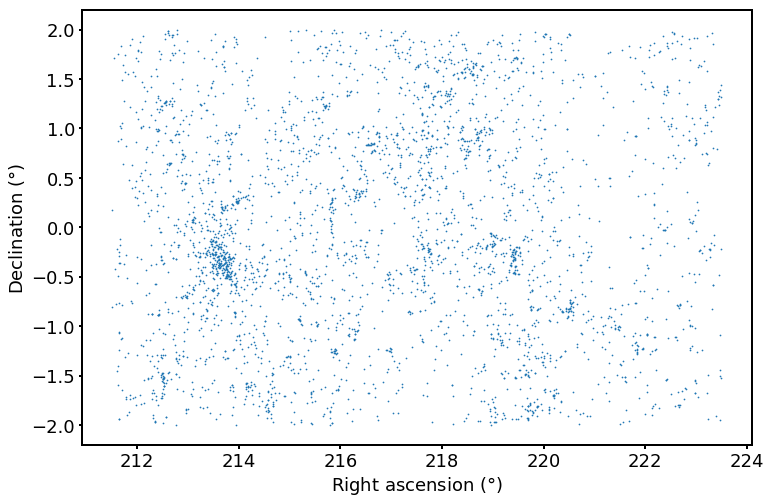

In [76]:
fig, ax = plt.subplots()
ax.set_xlabel(r'Right ascension ($\degree$)')
ax.set_ylabel(r'Declination ($\degree$)')
ax.scatter(data['RA'][redshift_range][magnitude_range],
           data['DEC'][redshift_range][magnitude_range], s=0.5);

In [68]:
# Find the solid angle covered by the sample
# assume that it's small enough to treat as a rectangular patch of sky
degrees_on_sky = 4 * np.pi * (180 / np.pi)**2
solid_angle = ((max_RA - min_RA) * (max_dec - min_dec)) / degrees_on_sky

# Calculate V_max
V_max = (solid_angle / 3) * r_max**3

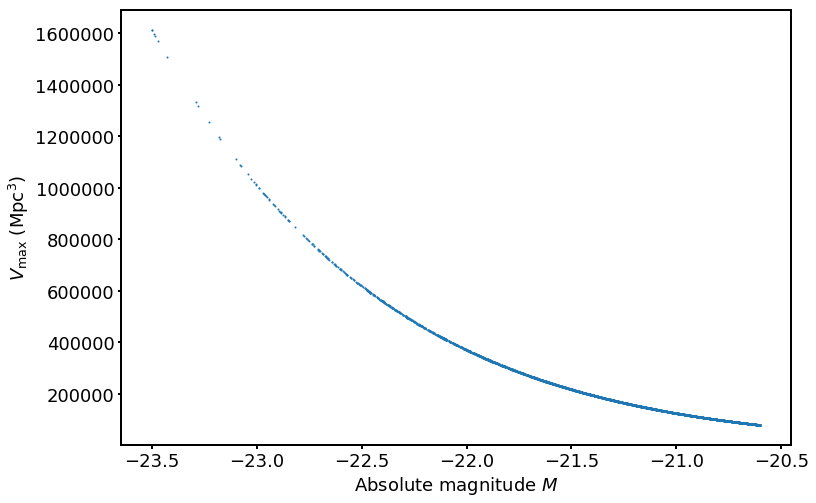

In [69]:
fig, ax = plt.subplots()
ax.set_xlabel(r'Absolute magnitude $M$')
ax.set_ylabel(r'$V_\mathrm{max}$ (Mpc${}^3$)')
ax.scatter(abs_mag_zfsel, V_max, s=1);

## (Finally!) construct luminosity function

In [88]:
dM = 0.2

num_abs_mag_bins = int(np.ceil((np.max(abs_mag_zfsel)
                                - np.min(abs_mag_zfsel)) / dM))
abs_mag_bins = np.linspace(np.min(abs_mag_zfsel), np.max(abs_mag_zfsel),
                           num_abs_mag_bins, endpoint=False)

lum_func = np.zeros(num_abs_mag_bins)
lum_counts = np.zeros(num_abs_mag_bins)  

# Value of luminosity function in each bin is found by summing 1/V_max
# for all objects with magnitudes within that bin
for i in range(num_abs_mag_bins - 1):
    in_bin = np.logical_and(abs_mag_zfsel < abs_mag_bins[i + 1],
                            abs_mag_zfsel > abs_mag_bins[i])
    lum_func[i] = np.sum(1 / V_max[in_bin]) * u.megaparsec**3 / dM
    lum_counts[i] = np.sum(in_bin)

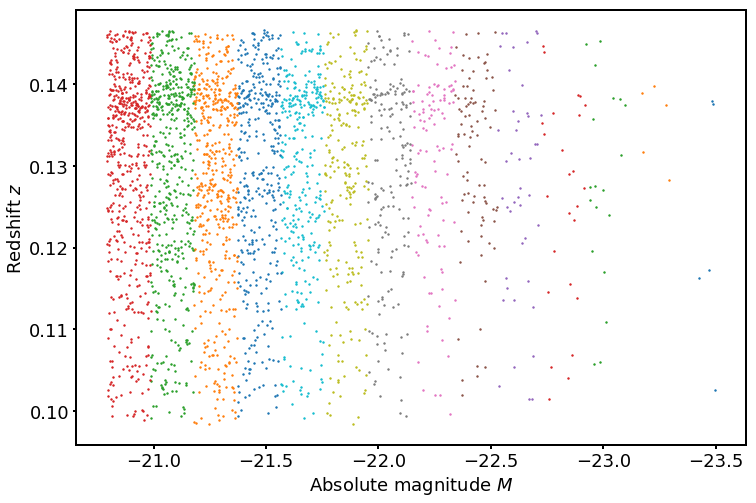

In [89]:
fig, ax = plt.subplots()
ax.invert_xaxis()
ax.set_xlabel(r'Absolute magnitude $M$')
ax.set_ylabel(r'Redshift $z$')
for i in range(num_abs_mag_bins - 1):
    in_bin = np.logical_and(abs_mag_zfsel < abs_mag_bins[i + 1],
                            abs_mag_zfsel > abs_mag_bins[i])
    ax.scatter(abs_mag_zfsel[in_bin], z_zfsel[in_bin], s=2)


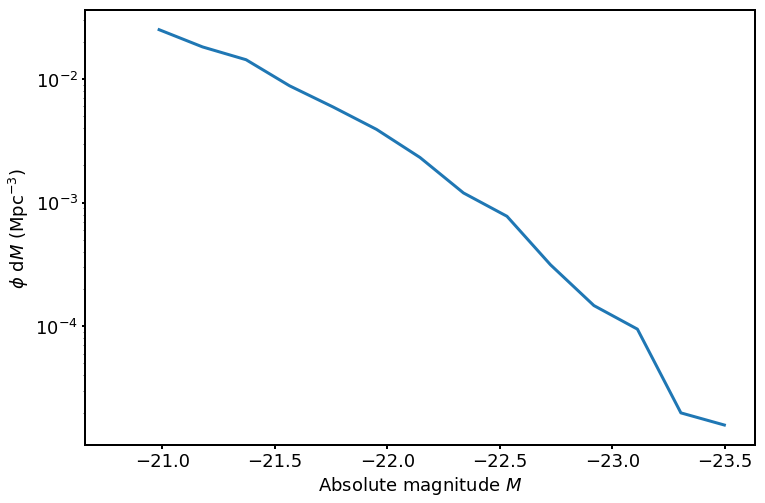

In [90]:
fig, ax = plt.subplots()
ax.invert_xaxis()
ax.set_yscale('log')
ax.set_xlabel(r'Absolute magnitude $M$')
ax.set_ylabel(r'$\phi$ d$M$ (Mpc${}^{-3}$)')
ax.plot(abs_mag_bins, lum_func);

## Fit Schechter to luminosity function

$$\phi(M)\mathrm{d}M=0.4\log(10)\phi^*10^{0.4(M^*-M)(\alpha+1)}\exp\left(-10^{0.4(M^*-M)}\right)\mathrm{d}M$$

In [91]:
# Fit is more successful if logs are used throughout
# Need to ingore any bins with no objects in them
log_lf = np.log10(lum_func[lum_func != 0])
filt_mag_bins = abs_mag_bins[lum_func != 0]

def schechter(M, phi_star, M_star, alpha):
    A = 0.4 * np.log(10)
    return np.log(A * phi_star * 10**(0.4 * (M_star - M) * (alpha + 1)) *
           np.exp(-10**(0.4 * (M_star - M))))

# initial values for phi*, M*, alpha
guess = (0.01, -20.5, -1.25)
bounds = (-np.inf, np.inf)
fit, cov = scipy.optimize.curve_fit(schechter, filt_mag_bins, log_lf, p0=guess)

err = np.sqrt(np.diag(cov))
print('''phi*  = {:.3e}+-{:.3e}
M*    = {:.3f}+-{:.3f}
alpha = {:.3f}+-{:.3f}'''.format(*itertools.chain(*zip(fit, err))))

phi*  = 8.763e-02+-2.453e-02
M*    = -22.771+-0.164
alpha = -1.706+-0.113


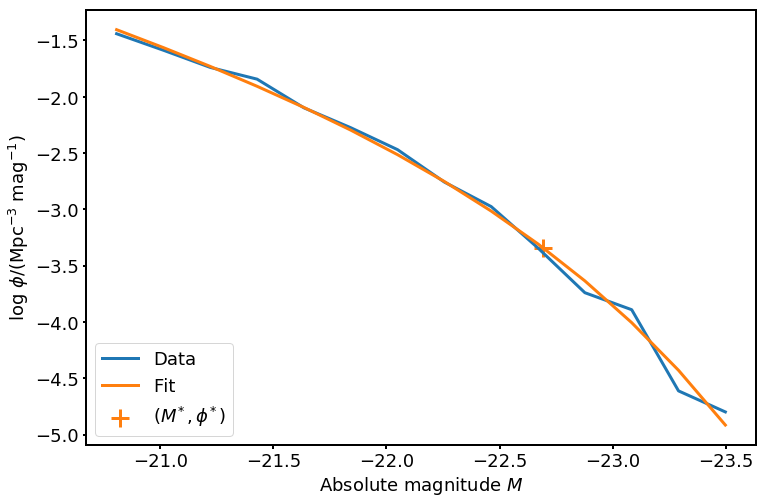

In [81]:
ord_abs_mag = np.argsort(filt_mag_bins)
abs_mag_srt = filt_mag_bins[ord_abs_mag]
log_lf_srt = log_lf[ord_abs_mag]

fig, ax = plt.subplots()
ax.invert_xaxis()
ax.set_xlabel(r'Absolute magnitude $M$')
ax.set_ylabel(r'log $\phi$/(Mpc${}^{-3}$ mag${}^{-1}$)')
ax.plot(abs_mag_srt, log_lf_srt, label='Data')
ax.plot(abs_mag_srt, schechter(abs_mag_srt, *fit), label='Fit')
ax.scatter(fit[1], schechter(fit[1], *fit), color='tab:orange',
           marker='+', s=300, label=r'($M^{\!*},\phi^{\!*}$)')
ax.legend(loc=3);

## Errors

The best way to estimate errors on the luminosity function is probably to use a technique like bootstrapping, where the data is repeatedly randomly subsampled (i.e. subsamples of the sources in each luminosity function bin are taken and used to calculate $\sum 1/V_{\mathrm{max}}$). The resulting values of $\phi$ should be approximately normally distributed, so their variance can then be used as an estimate of the error in the original sample.

In practice this may not be suitable for the bright end of the luminosity function, as there are very few sources to subsample from.

# Discussion

## Assumptions

* The chosen redshift range $0.1 < z < 0.15$ is sufficiently narrow that galaxy evolution effects are not significant. The width $\Delta z=0.05$ used was chosen arbitrarily, the range was selected by finding the $\Delta z$-width bin with the most sources in it.
* The chosen magnitude range is sufficiently narrow that the sample is complete (Hopefully this should hold, since by construction the faint magnitude limit I chose was the magnitude limit of the survey).
* The area covered on the sky is small enough that it can be treated as a square patch (this is a minor concern and just due to lazyness!).
* The cosmology used has $\Omega_{\mathrm{M}}=0.3$, $\Omega_\Lambda=0.7$, and $h=0.72$.

## Uncertainties

* There are likely measurement uncertainties in the survey's reported redshifts and apparent magnitudes.
* There are very few sources in the bins at the bright end of the luminosity function meaning the errors here on $\sum 1/V_{\mathrm{max}}$ will be large.

## Literature values

Montero-Dorta & Prada 2009 reports values for the best-fit Schechter parameters from SDSS DR6 data. Their results for the $r$ band are:

* $\phi^*=(0.35\pm 0.03)\times 10^{-2}\,\mathrm{Mpc}^{-3}$
* $M^*=-21.42\pm 0.04$
* $\alpha =-1.26\pm 0.02$

Unfortunately these values do differ significantly from the values I found, which were:

* $\phi^*=8.76\times 10^{-2}\,\mathrm{Mpc}^{-3}$
* $M^*=-22.77$
* $\alpha =-1.71$

My sample contains "only" ~3,500 sources; in reality all large-scale surveys have upwards of 100,000 sources and SDSS itself more than a million. This makes it likely that, especially at the bright end of the luminosity function where there are very few sources, the discrepancy is due to large errors in my calculated uncertainty function.

However, I would expect to get better agreement towards the faint end where there are more sources; however, SDSS has a much lower flux limit than the sample here, reaching four magnitudes fainter than my limit of $M=-20\,\mathrm{mag}$. Hence I am trying to fit the 'faint-end slope' to a considerably brighter population than that used in SDSS, which may account for the steeper asymptotic slope $\alpha$ I obtain.

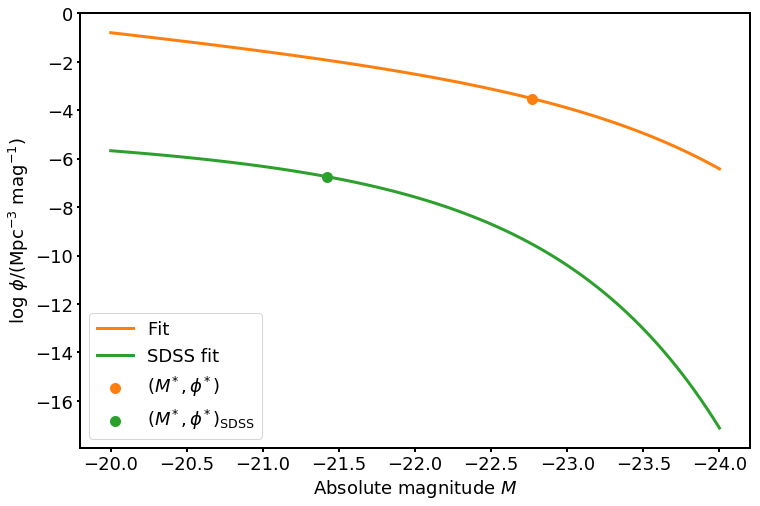

In [92]:
grid_mag = np.linspace(-24, -20, 100)

sdss_fit = (0.35e-2, -21.42, -1.26)

fig, ax = plt.subplots()
ax.invert_xaxis()
ax.set_xlabel(r'Absolute magnitude $M$')
ax.set_ylabel(r'log $\phi$/(Mpc${}^{-3}$ mag${}^{-1}$)')
ax.plot(grid_mag, schechter(grid_mag, *fit), color='tab:orange', label='Fit')
ax.scatter(fit[1], schechter(fit[1], *fit), color='tab:orange',
           marker='o', s=100, label=r'($M^{\!*},\phi^{\!*}$)')
ax.plot(grid_mag, schechter(grid_mag, *sdss_fit), color='tab:green',
        label='SDSS fit')
ax.scatter(sdss_fit[1], schechter(sdss_fit[1], *sdss_fit), color='tab:green',
           marker='o', s=100, label=r'($M^{\!*},\phi^{\!*}$)${}_{\mathrm{SDSS}}$')

ax.legend(loc=3);

# Deeper survey

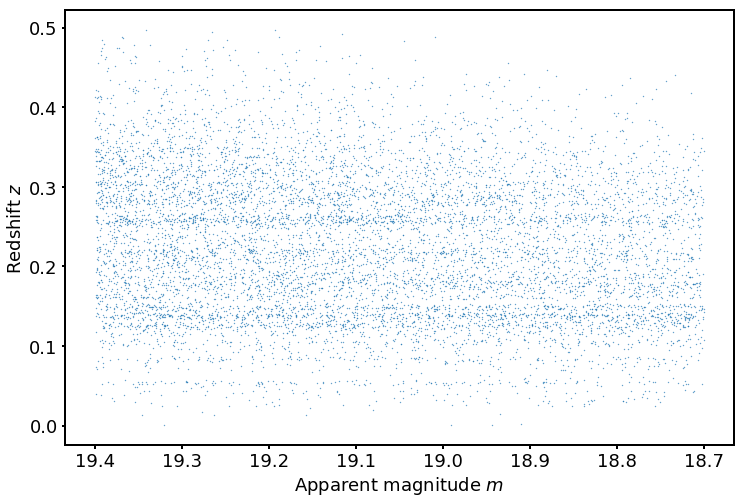

In [63]:
fig, ax = plt.subplots()
ax.invert_xaxis()
ax.set_xlabel(r'Apparent magnitude $m$')
ax.set_ylabel(r'Redshift $z$')
ax.scatter(data_deep['R_PETRO'], data_deep['Z'], s=0.1);

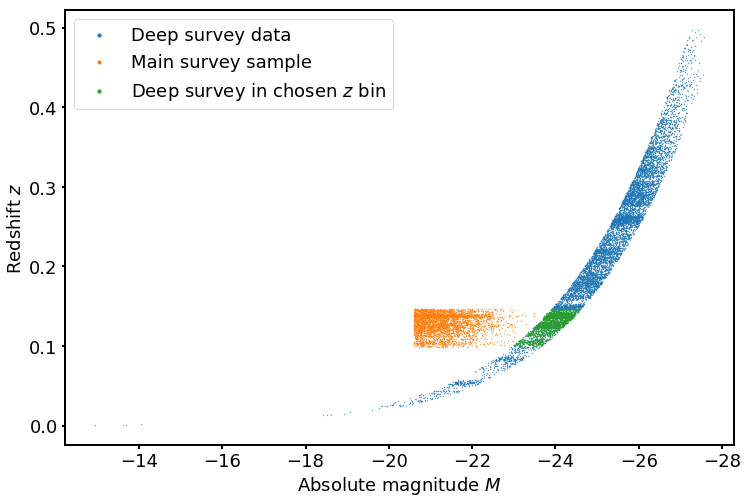

In [64]:
lum_dist_deep = lumdist(data_deep['Z'])
k_corr_deep = k_correction(data_deep['Z'])
abs_mag_deep = data_deep['R_PETRO'] - (5 * np.log10(lum_dist_deep.to(u.parsec)
                                                    / u.parsec) - 1) - k_corr_deep

z_range_deep = np.logical_and(data_deep['Z'] > z_bins[best_bin],
                                data_deep['Z'] < z_bins[best_bin + 1])

z_zsel_deep = data_deep['Z'][z_range_deep]
abs_mag_zsel_deep = abs_mag_deep[z_range_deep]

fig, ax = plt.subplots()
ax.invert_xaxis()
ax.set_xlabel(r'Absolute magnitude $M$')
ax.set_ylabel(r'Redshift $z$')
ax.scatter(abs_mag_deep, data_deep['Z'], s=0.1,
           label='Deep survey data')
ax.scatter(abs_mag_zfsel, z_zfsel, s=0.1,
           label='Main survey sample')
ax.scatter(abs_mag_zsel_deep, z_zsel_deep, s=0.1,
           label='Deep survey in chosen $z$ bin')
ax.legend(markerscale=10);

## Considerations

* Need to take sources from the same redshift range as the main survey.
* Since the main survey is assumed complete down to some magnitude limit, should avoid adding extra galaxies which overlap.
* Need to ensure $V_{\mathrm{max}}$ is calculated correctly - different prescription for the furthest distance an object is observable depending on whether it came from the main or deep survey sample.
* I used a rectangular window function to select my sample. However, the slope of the deep sample (see above plot) will mean that with $\Delta z=0.05$, it won't be possible to construct a continous sample from the two datasets. Hence a smaller $\Delta z$ will be needed.